In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import eurostat
import squarify 

In [2]:
year = 2020
color = ['red','blue','green','yellow']
states_dict = {'Rakousko':'AT', 
               'Belgie':'BE', 
               'Bulharsko':'BG',
               'Kypr':'CY',
               'České Republika':'CZ',
               'Německo':'DE',
               'Dánsko':'DK',
               'Estonsko':'EE',
               'Špenělsko':'ES',
               'Finsko':'FI',
               'Francie':'FR',
               'Chorvatsko':'HR',
               'Maďarsko':'HU',
               'Irsko':'IE',
               'Itálie':'IT',
               'Litva':'LT',
               'Lucembursko':'LU',
               'Lotyšsko':'LV',
               'Malta':'MT',
               'Nizozemsko':'NL',
               'Polsko':'PL',
               'Portugalsko':'PT',
               'Rumunsko':'RO',
               'Švédsko':'SE',
               'Slovinsko':'SI',
               'Slovensko':'SK',}

Načti a uprav dataframy

In [3]:
# Emise
df_sorce_emis = eurostat.get_data_df('env_air_gge')
df_emis = df_sorce_emis.rename(columns={'geo\\time': 'geo'})
df_emis = df_emis.query("src_crf == 'TOTX4_MEMONIA' and unit == 'MIO_T' and airpol == 'GHG'")

In [4]:
# Demografie
df_sorce_demo = eurostat.get_data_df('demo_pjan')
df_demo = df_sorce_demo.rename(columns={'geo\\time': 'geo'})
df_demo = df_demo.query("age == 'TOTAL' and sex == 'T'")

df_demo = df_demo.loc[df_demo['geo'].isin(states_dict.values())]
df_demo = df_demo[["geo", year]]

In [5]:
# Emise
df_emis = df_emis.loc[df_emis['geo'].isin(states_dict.values())]
df_emis = df_emis[["geo", year]]

Spoj dataframy

In [6]:
# "inner join is set by default"
df_merged = df_emis.merge(df_demo, on='geo', suffixes=('_emis', '_popul')) # "suffixes" rename columns so no .rename is needed 

Emise na obyvatele, název státu (nové sloupce do df a jejich úprava)

In [7]:
df_merged['em_na_oby'] = (df_merged[f'{year}_emis'] * 1000000) / df_merged[f'{year}_popul']
df_merged['stat'] = states_dict.keys()
df_merged = df_merged.set_index('stat')
df_merged = df_merged.sort_values(f'{year}_emis', ascending = False)

Kresli grafy

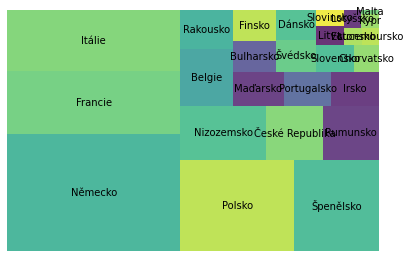

In [8]:
# Jak hodit Německo do levýho horního rohu? a musí to tak bejt?
squarify.plot(df_merged[f'{year}_emis'], label=df_merged.index, alpha=0.8)
plt.axis("off")
plt.show()

(0.0, 17.96971289298332, -0.5, 25.5)

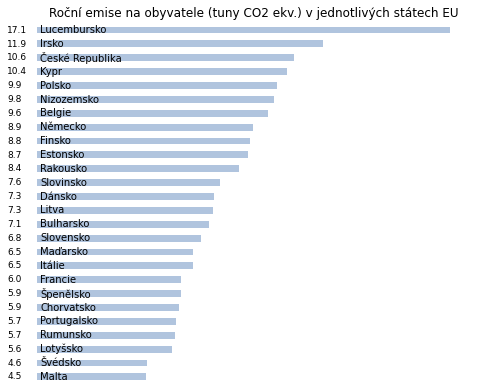

In [9]:
# sort df 
df_merged.sort_values(by='em_na_oby', ascending=False, inplace=True)

# Prepare fake bars of 0 length – to be able to plot labels on the edges of the horizontal bars.
fake_bar = plt.barh(df_merged.index, [0] * df_merged.index.size)
# add emission values on the left.        
plt.bar_label(fake_bar, labels=[f'{x}' for x in df_merged['em_na_oby'].round(1).sort_values()], padding=-30, fontsize=9)
# add country names on the right.
plt.bar_label(fake_bar, labels=df_merged.index[::-1], padding=3, fontsize=10)

# plot: for creating horizontal bar chatr use plot.barh()
df_merged['em_na_oby'].sort_values().plot.barh(title='Roční emise na obyvatele (tuny CO2 ekv.) v jednotlivých státech EU',
                                              figsize=(7,6), color="lightsteelblue")
plt.axis("off")

Nakonec vyhoď

Text(0, 0.5, '')

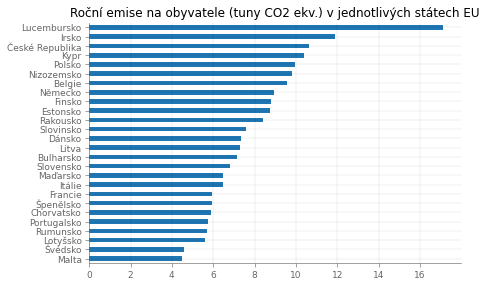

In [10]:
# Základní jednoduchý graf: zatím pracovně pro kontrolu
df_merged['em_na_oby'].sort_values().plot.barh(title='Roční emise na obyvatele (tuny CO2 ekv.) v jednotlivých státech EU')
plt.ylabel('')

Jiné možná někdy dál užitečné

In [11]:
# staré
# plt.bar_label(p, labels=["{:.1f}".format(x) for x in df_merged['em_na_oby'].sort_values()], padding=-30, fontsize=9)
# nové
# plt.bar_label(p, labels=[f'{x}' for x in df_merged['em_na_oby'].round(1).sort_values()], padding=-30, fontsize=9)

In [12]:
# df_demo_sorce['sex'].unique()

In [13]:
# add emission values on the left.        # tady za to labels Fanda doporučuje dát f'string a ne to co tam má jeňa
# plt.bar_label(p, labels=["{:.1f}".format(x) for x in df_merged['em_na_oby'].sort_values()], padding=-30, fontsize=9)